In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../Library")
import potentials
import build_system
import numpy as np
import matplotlib.pyplot as plt
import sampling
import visuals as vs
import utils
import generator
import training
import torch 
import os
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm
from sklearn import datasets
# warnings.filterwarnings('ignore'

plt.style.use("ggplot")

In [3]:
np.random.seed(seed=4)
torch.manual_seed(4)

# Section 0: The Dimer in LJ Bath system

In this notebook we'll explore the application of Boltzmann generators to a bistable dimer in a repulsive LJ bath. This system is a closer approximation of solid phase simulations. This system has a potential along the bond length between two particles. This new degree of freedom adds a new complexity not seen in the simpler simulations up to this point. In this first section we will cover how this system if built and setup.

## Section 0.1: System Building

This system is also built like the other systems we've simulated in this project. We have a `potential.DimerSimulation` class which is responsible for calculating the energy of configurations.

In [4]:
dimer = potentials.DimerSimulation()

Initial configurations for this system are built using `build_systems.build_dimer_coords()`, which places particles on a lattice with some noise. The `bond` keword argument is used to specify which two atoms in the orignal lattice are bonded together. This specification as a bond moves the coordinates of those particles to the first 4 indicies of the coordinate array ([x1, y1, x2, y2, x3, y3, ... xn, yn]).

In [5]:
coords = build_system.build_dimer_coords(bond = [17, 26], box = 7, noise = 0.2)

## Section 0.2: Energy Evaluation

Using the `dimer.get_energy(coords)` method we can calculate the energy of a given configuration. As you can see below, the initial lattice and noise configuration is not very energetically favorable.

In [6]:
dimer.get_energy(coords)

1432747.9044771413

## Section 0.3: System Visualization

We can also visualize the coordinates generated from `build_dimer_coords` fairly easily, with the following snippet:

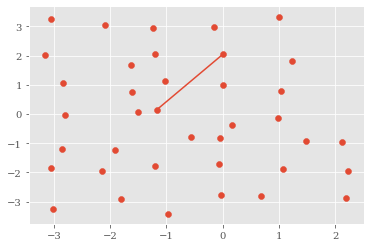

In [7]:
plt.scatter(*coords.T)
plt.plot(*coords[:2].T)

## Section 0.4: System Sampling

We can sample this system using the `sampling.MetropolisSampler` object used in the other two cases. For this system, Noe *et al.* used a $\sigma_{metro} = 0.02 $

In [8]:
sim_1 = sampling.MetropolisSampler(dimer, temp = 0.5, sigma = 0.02 * np.sqrt(0.5), stride = 10)

In [9]:
sim_1.run(coords, nsteps=10000)

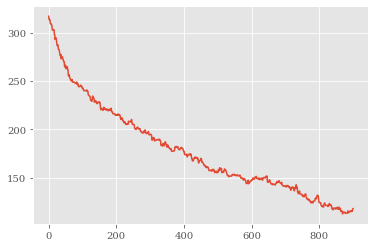

In [10]:
plt.plot(sim_1.etraj[100:])

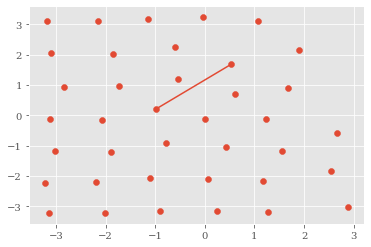

In [11]:
plt.scatter(*sim_1.xtraj[200].T)
plt.plot(*sim_1.xtraj[200][:2].T)

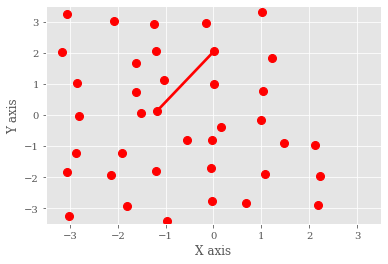

In [12]:
vs.make_2D_traj_bond(sim_1.xtraj[0:-1:50], box = [7,7], bonds = [[0, 1]])

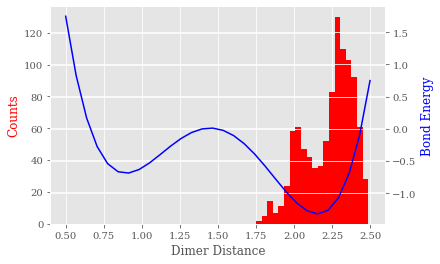

In [13]:
vs.plot_bond_sampling(sim_1.xtraj, dimer)

# Section 1: Sampling

For the Dimer simulation, the definition of the two configurations is a bit more complex than the last two toy systems. Now the two states are defined by the bond distance between the dimer particles. We define the two configurations as the extended and compact configurations. Where the compact configuration has a $d_{bond} \approx 0.9$I and the extended configuration has a $d_{bond} \approx 2.1$.

## Section 1.1: Equilibration

In order to get samples in both configuration we start two different simulations with an extended and conmpact starting configuration. These configurations are generated by placing particles on a lattice, adding some noise, and then defining the bonds between two particles. For the compact version, we define the bond between atoms 18 and 25 in the lattice. For the extended configuration, we define the bond between atoms 18 and 27 in the lattice. These simulations are then equilbrated to start the production runs.

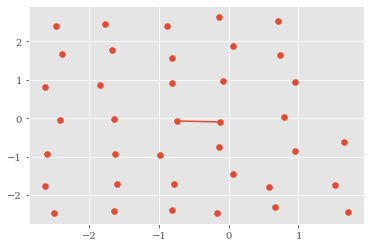

In [14]:
# Equilibration Sim, compact
initial_coords = build_system.build_dimer_coords()

# Plot initial coordinates
plt.scatter(*initial_coords.T)
plt.plot(*initial_coords[:2].T)

In [15]:
# Run compact equilibration simulation
eq_sim_c = sampling.MetropolisSampler(dimer, temp = 1, sigma = 0.02, stride = 100)
eq_sim_c.run(initial_coords, 10000)
eq_coords_c  = eq_sim_c.xtraj[-1]

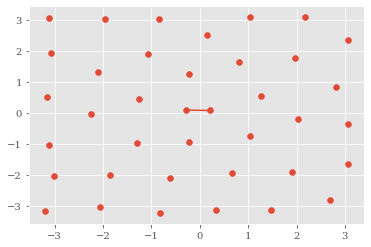

In [16]:
# Confirm the final configuration stays
# in the compact configuration
plt.scatter(*eq_coords_c.T)
plt.plot(*eq_coords_c[:2].T)

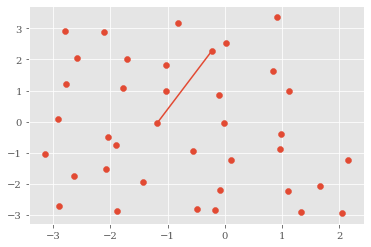

In [17]:
# Equilibration Sim, extended
initial_coords = build_system.build_dimer_coords(bond = [17, 26], box = 7, noise = 0.2)

# Plot initial coordinates
plt.scatter(*initial_coords.T)
plt.plot(*initial_coords[:2].T)

In [18]:
# Run equilibration for extended configuration
eq_sim_e = sampling.MetropolisSampler(dimer, temp = 0.5, sigma = 0.02, stride = 100)
eq_sim_e.run(initial_coords, 10000)
eq_coords_e = eq_sim_e.xtraj[-1]

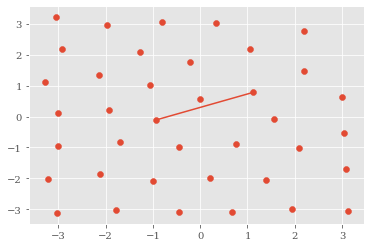

In [19]:
# Confirm final frame is in extended configuration
plt.scatter(*eq_coords_e.T)
plt.plot(*eq_coords_e[:2].T)

## Section 1.2: Production Simulations

Now that we have a proper intial configuration for both the extended and compact configurations, we can perform our production simulation to generate samples to train the Boltzman Generator. *Noe et al.* trained the Dimer Boltzmann generator with 50,000 samples from both configurations at a variety of temperatures.

In [20]:
# Compact configuration production simulation
T = 1
sigma = 0.02 * np.sqrt(T)
n_steps = 50000
stride = 10

prod_sim_c = sampling.MetropolisSampler(dimer, temp = T, sigma = sigma, stride = stride)
prod_sim_c.run(eq_coords_c, n_steps)

In [21]:
# Save compact trajecotries
x_prod_c = prod_sim_c.xtraj

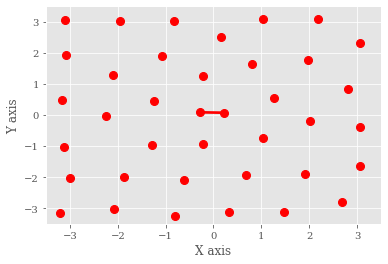

In [22]:
# Visualize compact trajectories
vs.make_2D_traj_bond(prod_sim_c.xtraj[0:-1:50], box = [7,7], bonds = [[0, 1]])

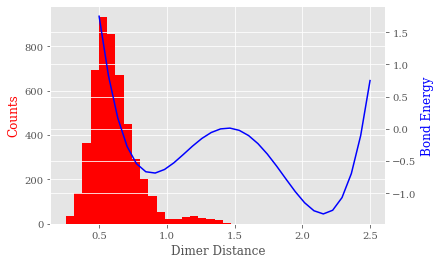

In [23]:
# Distribution along bond
vs.plot_bond_sampling(prod_sim_c.xtraj, dimer)

In [24]:
# Extended configuration production simulation
T = 1
sigma = 0.02 * np.sqrt(T)
n_steps = 50000
stide = 10

prod_sim_e = sampling.MetropolisSampler(dimer, temp = T, sigma = sigma, stride = stride)
prod_sim_e.run(eq_coords_e, n_steps)

In [25]:
# Save extended trajecotries
x_prod_e = prod_sim_e.xtraj

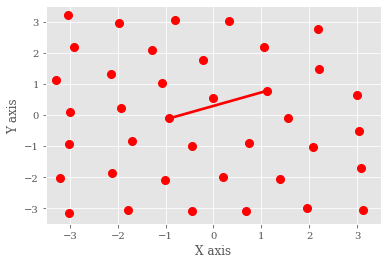

In [26]:
# Visualize extended trajectories
vs.make_2D_traj_bond(prod_sim_e.xtraj[0:-1:50], box = [7,7], bonds = [[0, 1]])

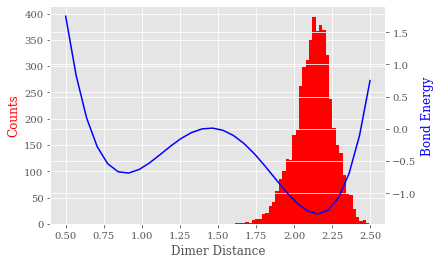

In [27]:
# Distribution along bond
vs.plot_bond_sampling(prod_sim_e.xtraj, dimer, bins = 40)

## Section 1.2: Hungarian Algorithm
In order to not have the boltzman generator learn the permutational invariance of this solvent molecules in this system, we apply to hungarian algorithm to the reassign the solvent particles to minimize their distance to a reference configuration. This ensures the solvent particles stays within a certain vacinity in the training set.

In [28]:
x_prod_c_ha = utils.apply_hungarian_alg(x_prod_c[-1], x_prod_c)

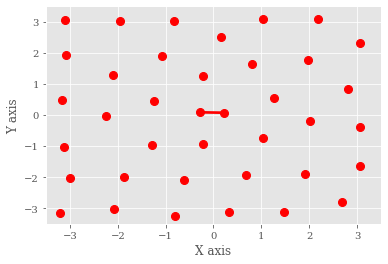

In [29]:
vs.make_2D_traj_bond(x_prod_c_ha[0:-1:50], box = [7,7], bonds = [[0, 1]])

In [30]:
x_prod_e_ha = utils.apply_hungarian_alg(x_prod_e[-1], x_prod_e)

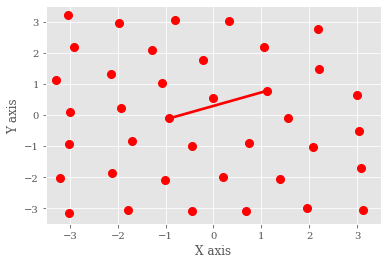

In [31]:
vs.make_2D_traj_bond(x_prod_e_ha[0:-1:50], box = [7,7], bonds = [[0, 1]])

# Section 2: Training Boltzman Generators

Now that we have samples in both configurations with the removal of solvent permuational invariance, we can start training Boltzmann generators on the simulationd data.

## Section 2.1: ML Loss

We start with the ML loss boltzmann generator which trains the inverse transformation to maximize the probability of generating gaussian samples in the latent space. Our training set will consist of the samples from both the compact and extended configurations. The format of these arrays will also be adjust to have a shape of $(N_{samples}, 76)$, to treat the $X$ and $Y$ coordinates of each particle as a feature.

For all training models we will use a training set of $N_x = 10000$ with batches of $N_b = 800$.

The realNVP network has 8 blocks, with the $S$ and $T$ transformations having 3 hidden layers and 200 nodes per hidden layer.

In [32]:
# Dataset
x_samples = np.concatenate((x_prod_c_ha, x_prod_e_ha))
x_samples = x_samples.reshape(x_samples.shape[0], x_samples.shape[1] * x_samples.shape[2])
np.random.shuffle(x_samples)

Loading the trained ML model ...
Total loss: -149.83673095703125


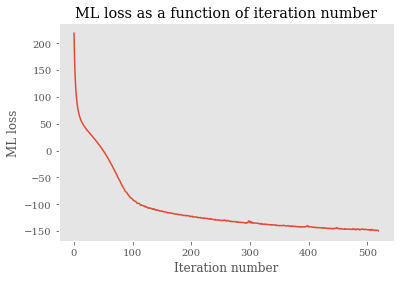

In [33]:
params_ML = {"n_blocks":     8,
             "dimension" :   76,
             "reshape" : (38, 2),
             "n_nodes":    200,
             "n_layers":     3,
             "n_epochs":  40,
             "batch_size": 800,
             "LR":      0.0001,
             "prior_sigma": 1}
w_loss = [1, 0, 0]

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_ML = BoltzmannGenerator_ML.build(dimer)
if os.path.isfile('Trained_models/Dimer/model_ML') is True:  
    print("Loading the trained ML model ...")
    model_ML, loss = BoltzmannGenerator_ML.load(model_ML, 'Trained_models/Dimer/model_ML')
else:   
    print("Training model_ML ...")
    BoltzmannGenerator_ML.train(model_ML, w_loss, x_samples=x_samples)
    BoltzmannGenerator_ML.save(model_ML, 'Trained_models/Dimer/model_ML')
    loss = BoltzmannGenerator_ML.loss_iteration
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/Dimer_training_ML_loss.png', dpi=600)

We save the model with `BoltzmannGenerator_ML.save`, such that we don't have to rerun the training every time this notebook is run. This will allow us to use previously trained models while computing the free energy calculations.

We can plot the loss as function of iteration number to confirm that the model has converged to a final solution.

Below we generate new model configurations using the Boltzman generator trained on our sample data. We plot these generated distributions to confirm we the model is producing reasonable results.

In [34]:
z_samples = BoltzmannGenerator_ML.prior.sample_n(5000)
z_samples_np = z_samples.detach().numpy()

x_generated, log_R_zx = model_ML.generator(z_samples)
x_generated_np = x_generated.detach().numpy().reshape((5000, 38, 2))

/home/lenny/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


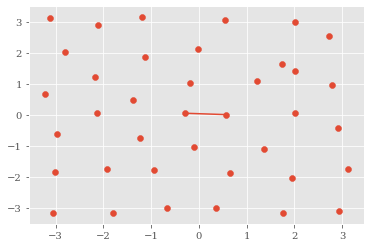

In [35]:
plt.scatter(*x_generated_np[0].T)
plt.plot(*x_generated_np[0][:2].T)

In the 76-D space that the dimer system represents, the visualization of the multivariate gaussian becomes a good deal harder. When plotting the inverse transform of the $x_1$ and $x_2$ coordinates (1st and 2nd particle x coordinate) for the extended and compact simulation data, we see that the separated real space distribution is mapped to a multivariate gaussian, however the mapping does not completely segregate the two samples. Looking at the forward generation of samples, we see decent sampling between both states, however no real separation between the extended and compact states.

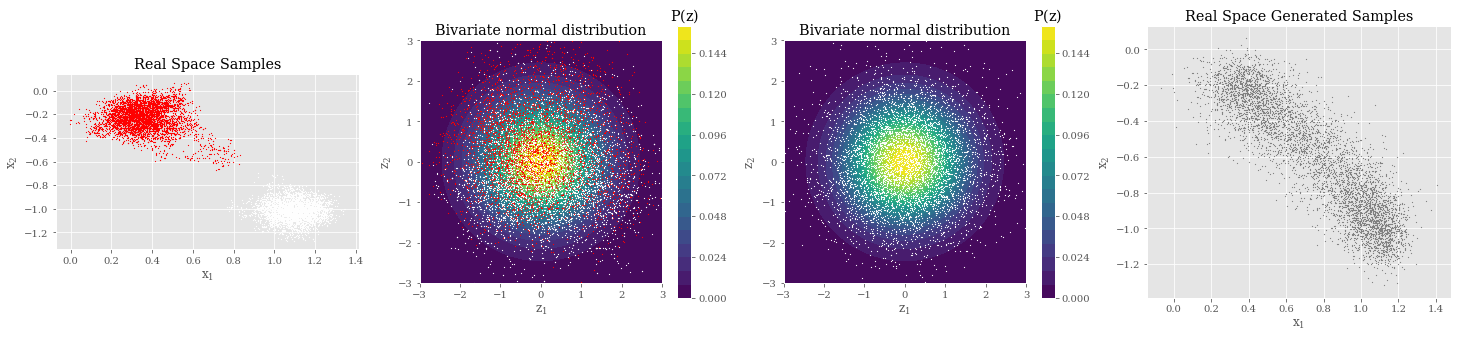

In [36]:
vs.dimer_2D_generator_result(dimer, model_ML, [x_prod_c_ha, x_prod_e_ha])

Here we define the mask used for the affine coupling layers. This mask uses the first 38 dimensions of a sample to transform the latter 28 dimensions. The second mask then uses the latter 28 dimensions to transform the first 38 dimensions.

## Section 2.2: KL Loss

In [ ]:
params_KL = {"n_blocks":     8,
             "dimension" :   76,
             "reshape" : (38, 2),
             "n_nodes":    200,
             "n_layers":     3,
             "n_epochs":  40,
             "batch_size": 800,
             "LR":      0.0001,
             "prior_sigma": 1}

w_loss = [0, 1, 0]

BoltzmannGenerator_KL = training.BoltzmannGenerator(model_params=params_KL)
model_KL = BoltzmannGenerator_KL.build(dimer)
if os.path.isfile('Trained_models/Dimer/model_KL') is True:  
    print("Loading the trained KL model ...")
    model_KL, loss = BoltzmannGenerator_KL.load(model_KL, 'Trained_models/Dimer/model_KL')
elif os.path.isfile('Trained_models/Dimer/model_ML') is True:
    print("Loading the trained ML model ...")
    model_KL, loss_ML = BoltzmannGenerator_KL.load(model_KL, 'Trained_models/Dimer/model_ML')
    print("Training the KL model based on the trained ML model ...")
    z_samples = BoltzmannGenerator_KL.prior.sample_n(len(x_samples)).detach().numpy()  
    BoltzmannGenerator_KL.train(model_KL, w_loss, z_samples=z_samples)
    BoltzmannGenerator_KL.save(model_KL, 'Trained_models/DoubleWell/model_KL', previous_loss=loss_ML)
    loss = BoltzmannGenerator_KL.loss_iteration  # ML loss will be appended to KL loss automatically by specifying previos_loss
else:
    print("Error! No parameter files of ML or KL model found.") 
    print("(Note: The Boltzmann should be trained on the ML loss before it is trained on KL loss.)")
    sys.exit()

Loading the trained ML model ...
Total loss: -149.83673095703125
Training the KL model based on the trained ML model ...


# Section 3: Free Energy Calculation

Now that we have a quick way to generate samples from the dimer simulation, we can quickly computer free energy profiles along the bond length of the dimer, without having to run further simulations. This in theory should be much less computationally expensive than traditional enhanced sampling methods, as accurate free energy profiles can be generated without having to observer the transition state in the simulations.

## Section 3.1: Generating data

To begin the free energy calculation, we first load our model and generate $50,000$ datapoints of the model. We also need to reshape these data points to the dimensionality required by the energy function $(N_{steps}, N_{particles}, N_{dimensions})$

In [ ]:
model_ML = torch.load("Dimer_training_ML_loss_T_1")

In [ ]:
z_samples = model_ML.prior.sample_n(5000)
z_samples_np = z_samples.detach().numpy()

x_generated, log_R_zx = model_ML.generator(z_samples)
x_generated = x_generated.detach().numpy().reshape((5000, 38, 2))

Below we visualize the first frame of the generate samples to confirm that our generator is producing reasonable samples.

In [ ]:
plt.scatter(*x_generated[0].T)
plt.plot(*x_generated[0][:2].T)

A video representation of the generate samples can also be made, but is computationally expensive for large numbers of samples.

In [ ]:
vs.make_2D_traj_bond(x_generated[0:-1:50], box = [7,7], bonds = [[0, 1]])

We also take a look at the distribution of bond lengths generated by the Boltzman generator compared to the energy of the bond length, to confirm that they are no major outliers. We see that the dimer bond is moderately well sampled.

In [ ]:
vs.plot_bond_sampling(x_generated, dimer, bins = 40)

Next we look at the distribution of energy of the generated configuration. A cutoff of 750 was placed on the energy, as the distribution had a long tail that extended to extremely large energy values. We believe using the KL loss should shorten the tail in the energy distribution, and better sample the Boltzmann distribution.

In [ ]:
e_generated = []
for x in x_generated:
    e_generated.append(dimer.get_energy(x))

In [ ]:
e_generated = np.array(e_generated)
e_generated_no_outliers = e_generated[e_generated < 750]
plt.hist(e_generated_no_outliers, bins = 30)
plt.xlabel("Energy")
plt.ylabel("Counts")

## Section 3.2: Weighted histogram free energy method

Similar to how we performed the free energy calculations in the previous two examples, we apply a weighted histogram method for calculating the free energy profile along a reaction coordinate of interest. The reaction coordinate in this case is the distance between the two dimer particles.

In [ ]:
def dimer_distance(coords):
    return np.linalg.norm(coords[:, 0, :] - coords[:, 1, :], axis = 1)
rc_generated = dimer_distance(x_generated)

We must also define a set of statistical weights of each sample, which we will use to reweight the generated samples to the Boltzmann distribution.

In [ ]:
u_x = model_ML.calculate_energy(torch.from_numpy(x_generated), space="configuration")

In [ ]:
u_z = model_ML.calculate_energy(z_samples, space="latent")

Below we compute the weights for the Dimer in solution system with the ML loss model. We run into an issue here where the statistical weights used to reweight the generated distribution to the Boltzmann distribution are extremely small. 

In [ ]:
log_R_zx

In [ ]:
u_x

In [ ]:
weights = torch.exp(-u_x + u_z + log_R_zx)
weights = weights.detach().numpy()

In [ ]:
counts, bins = np.histogram(rc_generated, bins = 200, weights = weights)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f, color = "blue", s = 3)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")